In [1]:
import sys
import os
import pandas as pd
sys.path.append('../../../Fedot.Industrial')
from fedot_ind.core.architecture.postprocessing.cv_results_parser import *

In [2]:
exp_root = '/media/n31v/data/results/minerals200'
exps = os.listdir(exp_root)

In [ ]:
for exp in exps:
    create_mean_exp(os.path.join(exp_root, exp))

In [4]:
import shutil
for exp in filter(lambda x: 'SFP' in x, exps):
    path = os.path.join(exp_root, exp, 'mean')
    shutil.rmtree(path)
    print(f'{path} removed.')

FileNotFoundError: [Errno 2] No such file or directory: '/media/n31v/data/results/minerals200/ResNet18_SFP_energy_threshold-0.9/mean'

In [2]:
from typing import Dict

def exp_list(config: Dict, folds = [0, 1],  n = [0, 1, 2, 3, 4]):
    pruning_ratio = [p['pruning_ratio'] for p in config['sfp_params']['zeroing']['percentage']]
    energy_threshold = [e['energy_threshold'] for e in config['sfp_params']['zeroing']['energy']]
    hoer_loss_factor = config['svd_params']['hoer_loss_factor']
    orthogonal_loss_factor = config['svd_params']['orthogonal_loss_factor']
    root = f"/media/n31v/data/results/{config['ds_name']}/{config['model_name']}"
    exps = {'Baseline': f"{root}/mean"}
    sfp_exps = {
        'energy': {f'SFP energy {e}': f'{root}_SFP_energy_threshold-{e}/mean' for e in energy_threshold},
        'percentage': {f'SFP {pr * 100}%': f'{root}_SFP_pruning_ratio-{pr}/mean' for pr in pruning_ratio},
    }

    svd_exps = {
        'channel': {f'Hoer {hoer} Ort {ort}': f'{root}_SVD_channel_O-{ort}_H-{hoer}/mean' for hoer in hoer_loss_factor for ort in orthogonal_loss_factor},
        'spatial': {f'Hoer {hoer} Ort {ort}': f'{root}_SVD_spatial_O-{ort}_H-{hoer}/mean' for hoer in hoer_loss_factor for ort in orthogonal_loss_factor},
    }
    return exps, sfp_exps, svd_exps

In [3]:
from exp_parameters import TASKS
ds_name = 'minerals200'
baseline, sfp_exps, svd_exps = exp_list(TASKS[ds_name])
svd_channel = compare_svd_results(
    baseline=baseline['Baseline'],
    svd_exps=svd_exps['channel'],
    metric='f1'
)
svd_spatial = compare_svd_results(
    baseline=baseline['Baseline'],
    svd_exps=svd_exps['spatial'],
    metric='f1'
)
sfp_energy = compare_sfp_results(
    baseline=baseline['Baseline'],
    sfp_exps=sfp_exps['energy'],
    metric='f1'
)
sfp_per = compare_sfp_results(
    baseline=baseline['Baseline'],
    sfp_exps=sfp_exps['percentage'],
    metric='f1'
)
get_best_metric(
    exp_path=baseline['Baseline'],
    metric='f1'
)

0.8090092000878016

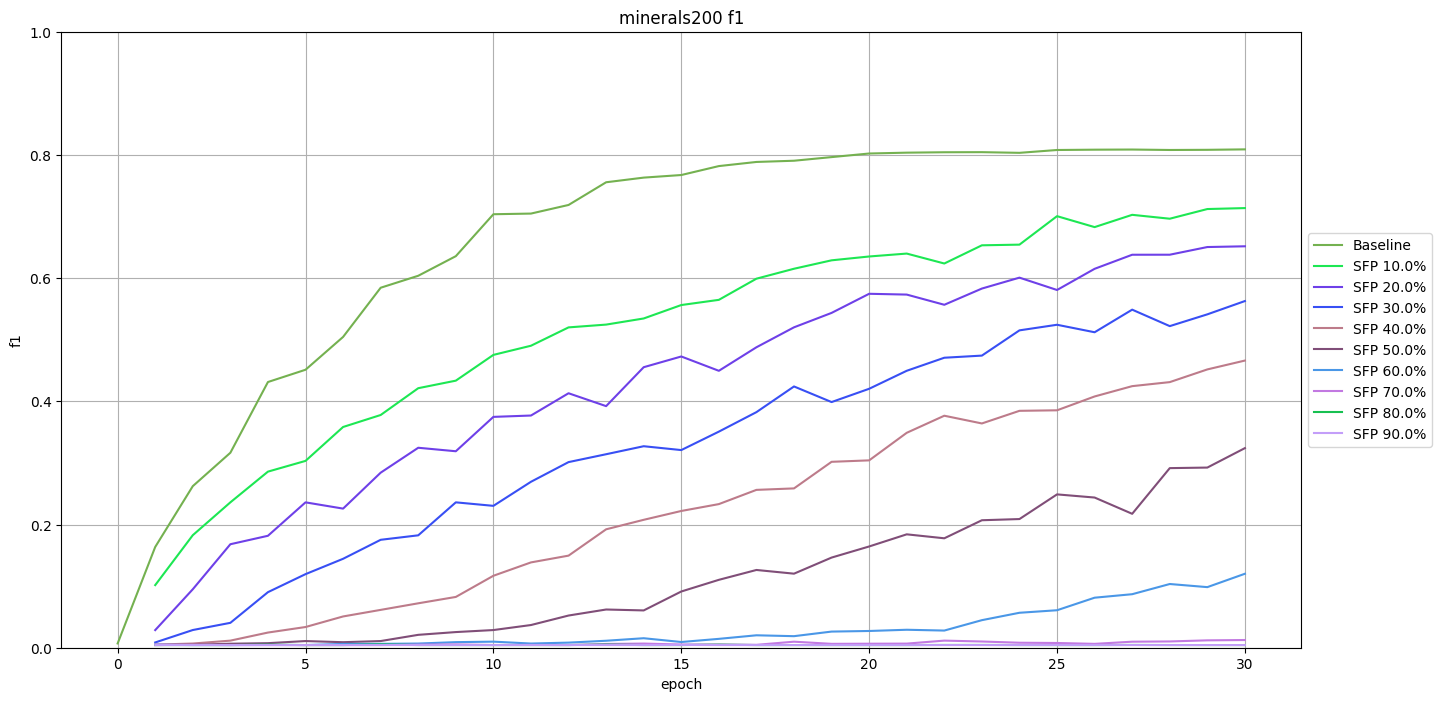

In [4]:
exps = {**baseline}
exps.update(sfp_exps['percentage'])
ax = show_train_scores(
    exps=exps,
    metric='f1',
    show_std=False,
    title=f'{ds_name} f1',
    xlabel='epoch',
    ylabel='f1',
    ylim=(0, 1),
    # saving_path='f1.png'
)

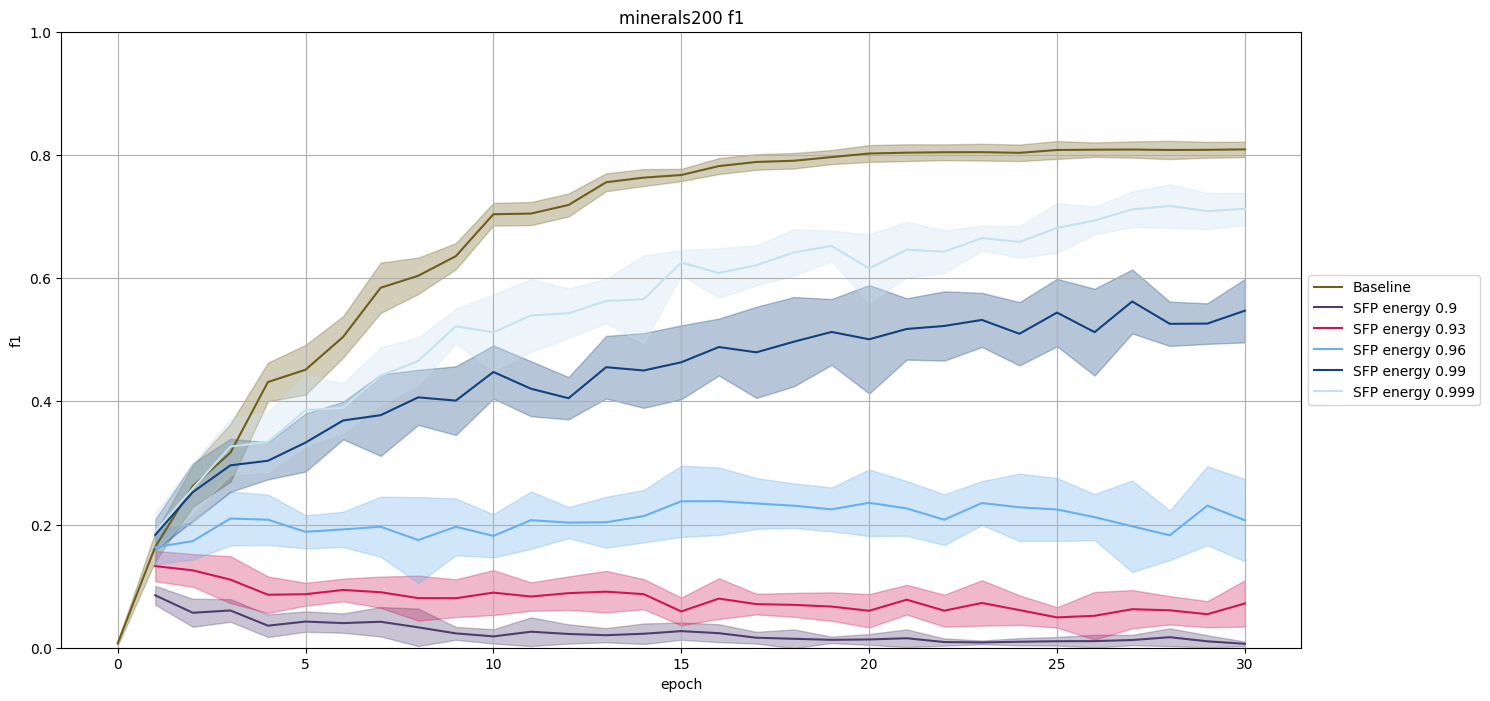

In [5]:
exps = {**baseline}
exps.update(sfp_exps['energy'])
ax = show_train_scores(
    exps=exps,
    metric='f1',
    show_std=True,
    title=f'{ds_name} f1',
    xlabel='epoch',
    ylabel='f1',
    ylim=(0, 1),
    # saving_path='f1.png'
)

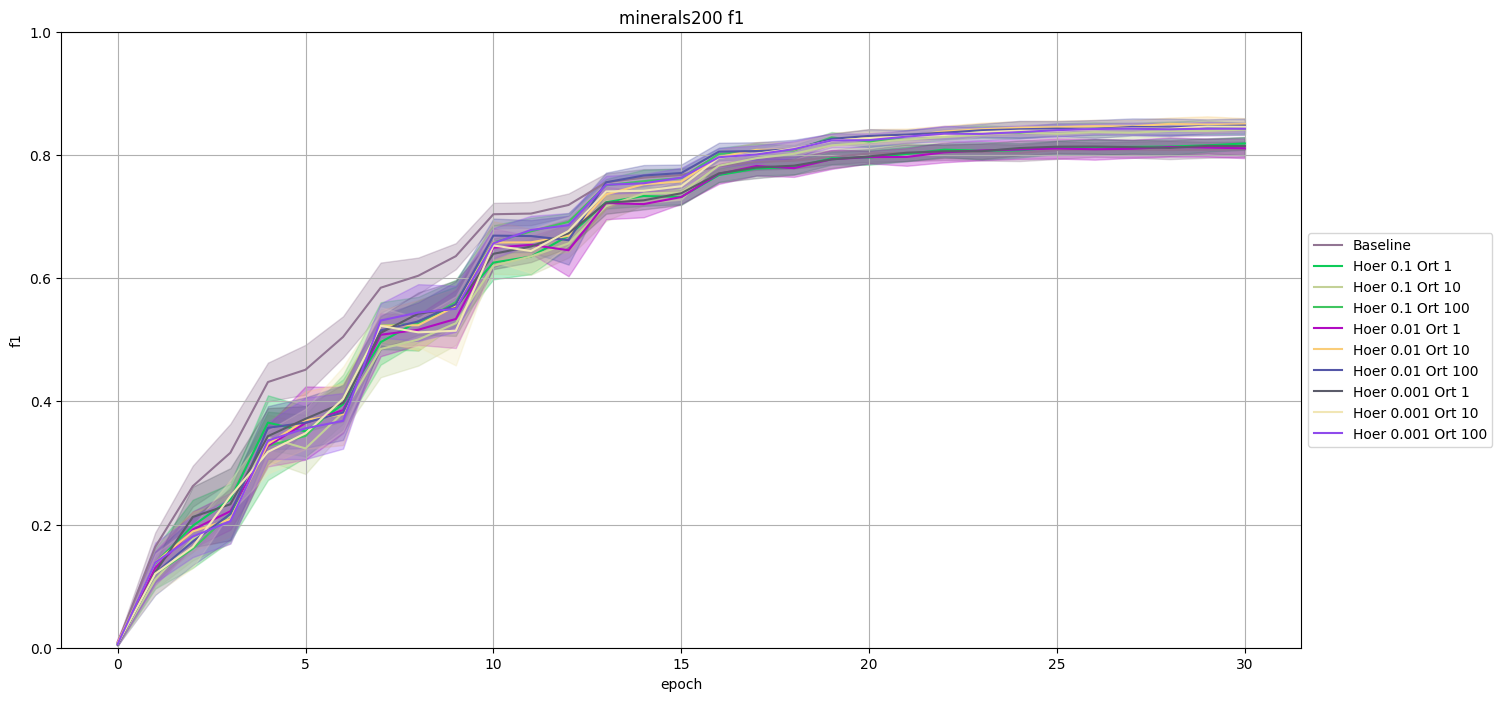

In [5]:
exps = {**baseline}
exps.update(svd_exps['channel'])
ax = show_train_scores(
    exps=exps,
    metric='f1',
    show_std=True,
    title=f'{ds_name} f1',
    xlabel='epoch',
    ylabel='f1',
    ylim=(0, 1),
    # saving_path='f1.png'
)

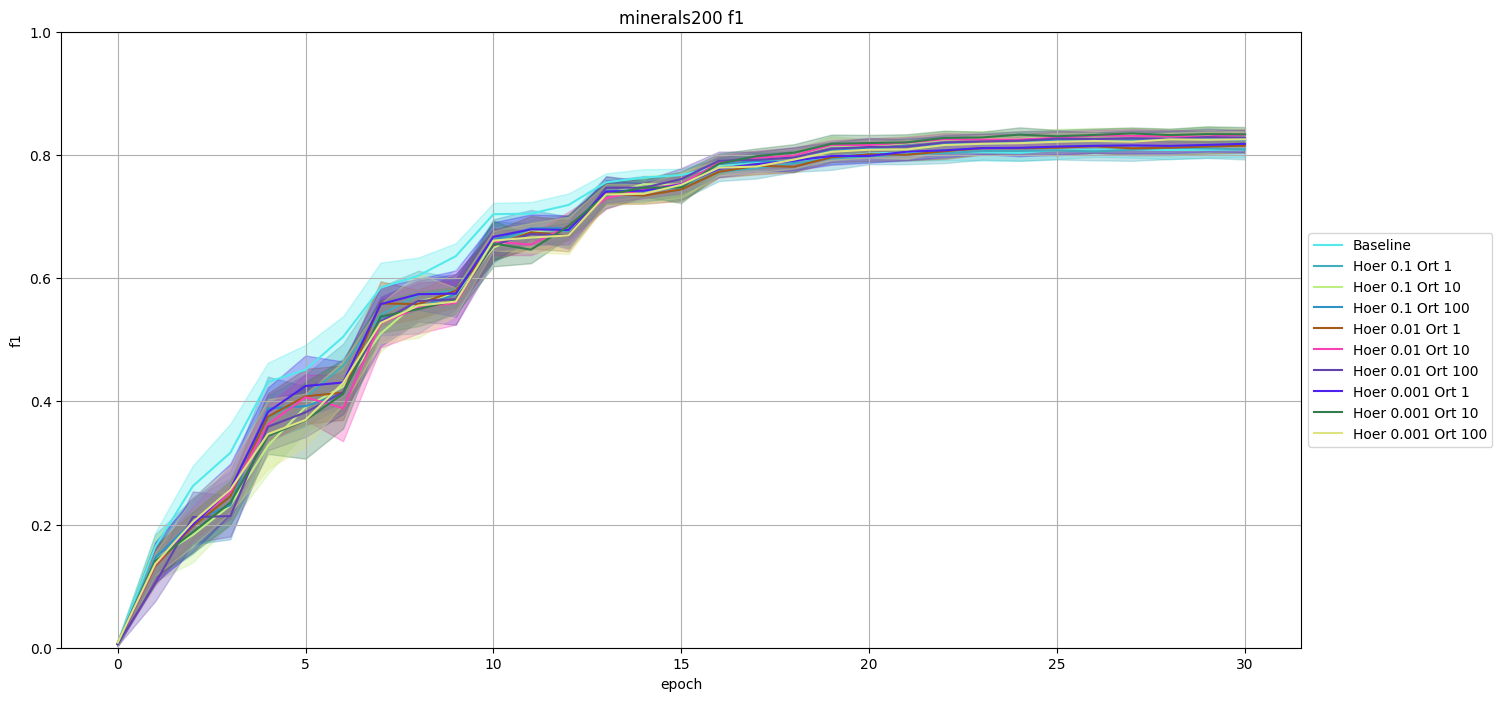

In [6]:
exps = {**baseline}
exps.update(svd_exps['spatial'])
ax = show_train_scores(
    exps=exps,
    metric='f1',
    show_std=True,
    title=f'{ds_name} f1',
    xlabel='epoch',
    ylabel='f1',
    ylim=(0, 1),
    # saving_path='f1.png'
)

In [9]:
percent = 97
print(f"SFP per prun: {sfp_per.loc[sfp_per['pruned']>=percent]['size'].min():.1f}")
print(f"SFP per ft: {sfp_per.loc[sfp_per['fine-tuned']>=percent]['size'].min():.1f}")
print(f"SFP energy prun: {sfp_energy.loc[sfp_energy['pruned']>=percent]['size'].min():.1f}")
print(f"SFP energy ft: {sfp_energy.loc[sfp_energy['fine-tuned']>=percent]['size'].min():.1f}")

df = svd_channel['Hoer 0.1 Ort 10']
print(f"SVD channel prun: {df.loc[df['pruned']>=percent].index.min():.1f}")
print(f"SVD channel ft: {df.loc[df['fine-tuned']>=percent].index.min():.1f}")
df = svd_spatial['Hoer 0.1 Ort 10']
print(f"SVD spatial prun: {df.loc[df['pruned']>=percent].index.min():.1f}")
print(f"SVD spatial ft: {df.loc[df['fine-tuned']>=percent].index.min():.1f}")

SFP per prun: nan
SFP per ft: 65.9
SFP energy prun: nan
SFP energy ft: 85.7
SVD channel prun: 109.9
SVD channel ft: 109.9
SVD spatial prun: 122.7
SVD spatial ft: 122.7


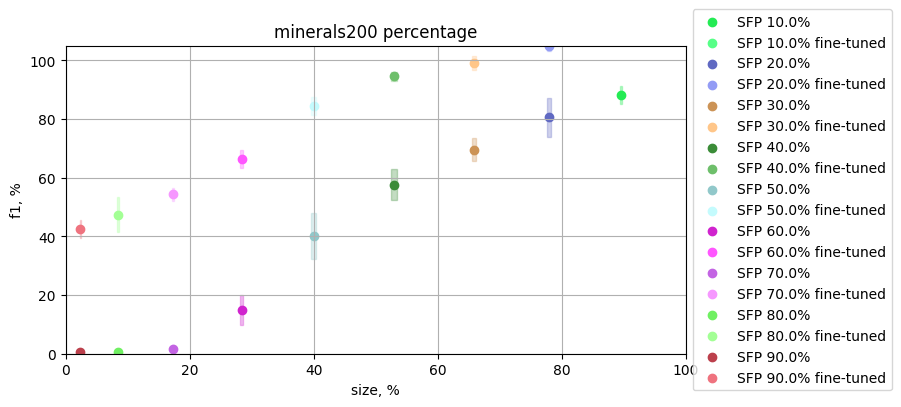

In [10]:
ax = show_sfp_results(
    sfp_exps=sfp_per,
    figsize=(8, 4),
    title=f'{ds_name} percentage',
    xlabel='size, %',
    ylabel='f1, %',
    ylim=(0, 105),
    xlim=(0, 100)
)

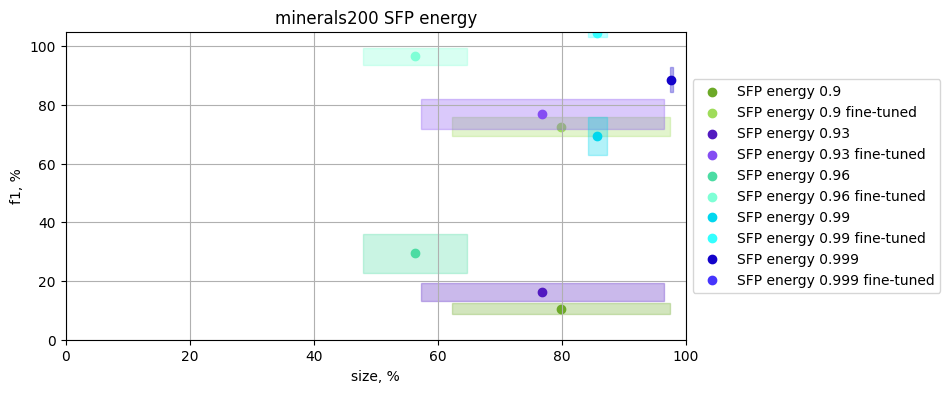

In [11]:
ax = show_sfp_results(
    sfp_exps=sfp_energy,
    figsize=(8, 4),
    title=f'{ds_name} SFP energy',
    xlabel='size, %',
    ylabel='f1, %',
    ylim=(0, 105),
    xlim=(0, 100)
)

In [21]:
channel_exps = {k: v for k, v in svd_channel.items() if 'Hoer 0.1' in k}

In [23]:
channel_exps = {k: v for k, v in svd_channel.items() if k.endswith('Ort 10')}

In [12]:
channel_exps = {k: v[['pruned', 'fine-tuned']] for k, v in svd_channel.items() if 'Hoer 0.1' in k }

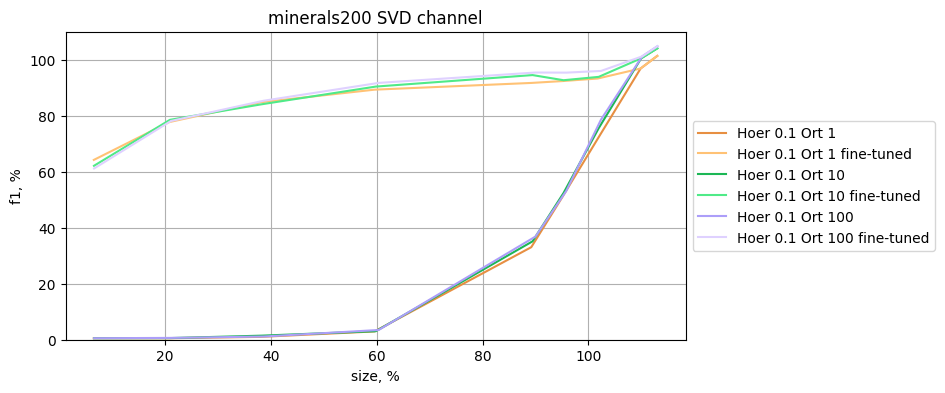

In [13]:
ax = show_svd_results(
    svd_exps=channel_exps,
    figsize=(8, 4),
    title=f'{ds_name} SVD channel',
    xlabel='size, %',
    ylabel='f1, %',
    ylim=(0, 110),
    # xlim=(0, 100)
)

In [13]:
spatial_exps = {k: v for k, v in svd_spatial.items() if 'Hoer 0.1' in k}

In [44]:
spatial_exps = {k: v for k, v in svd_spatial.items() if k.endswith('Ort 10')}

In [14]:
spatial_exps = {k: v[['pruned', 'fine-tuned']] for k, v in svd_spatial.items() if 'Hoer 0.1' in k }

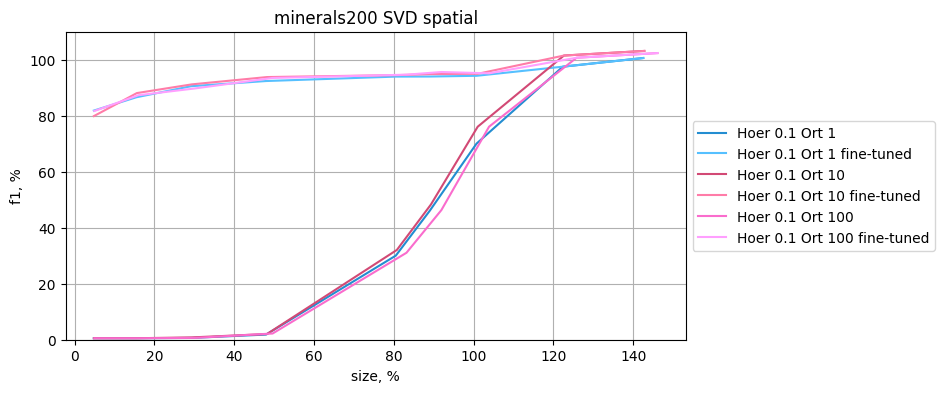

In [15]:
ax = show_svd_results(
    svd_exps=spatial_exps,
    figsize=(8, 4),
    title=f'{ds_name} SVD spatial',
    xlabel='size, %',
    ylabel='f1, %',
    ylim=(0, 110),
    # xlim=(0, 100)
)

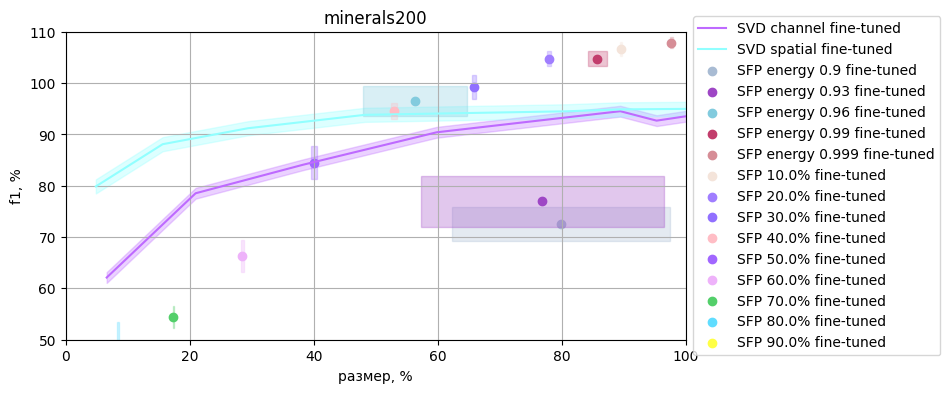

In [17]:
ax = show_svd_sfp_results(
    sfp_exps=pd.concat([sfp_energy, sfp_per])[['size', 'size std', 'fine-tuned', 'fine-tuned std']],
    svd_exps={
        'SVD channel': svd_channel['Hoer 0.1 Ort 10'][['fine-tuned', 'fine-tuned std']],
        'SVD spatial': svd_spatial['Hoer 0.1 Ort 10'][['fine-tuned', 'fine-tuned std']],
    },
    figsize=(8, 4),
    title=f'{ds_name}', # best fine-tuned',
    xlabel='размер, %',
    ylabel='f1, %',
    ylim=(50, 110),
    xlim=(0, 100)
)